In [1]:
# -- import packages --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
import warnings

warnings.filterwarnings('ignore')

In [2]:
# -- import dataset --
churn_df = pd.read_csv('bank_data.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Part 1 - Data Exploration
### Check details in file "churn-predict"
### 

## Part 2 - feature preprocessing

In [3]:
# ordinal encoding
churn_df['Gender'] = churn_df['Gender'] == 'Female'

In [4]:
# one hot encoding
churn_df = pd.get_dummies(churn_df, columns=['Geography'], drop_first=True)

In [5]:
# Get feature space by dropping useless feature
to_drop = ['RowNumber','CustomerId','Surname','Exited']
X = churn_df.drop(to_drop, axis=1)

In [6]:
X.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain
0,619,True,42,2,0.00,1,1,1,101348.88,0,0
1,608,True,41,1,83807.86,1,0,1,112542.58,0,1
2,502,True,42,8,159660.80,3,1,0,113931.57,0,0
3,699,True,39,1,0.00,2,0,0,93826.63,0,0
4,850,True,43,2,125510.82,1,1,1,79084.10,0,1
5,645,False,44,8,113755.78,2,1,0,149756.71,0,1
6,822,False,50,7,0.00,2,1,1,10062.80,0,0
7,376,True,29,4,115046.74,4,1,0,119346.88,1,0
8,501,False,44,4,142051.07,2,0,1,74940.50,0,0
9,684,False,27,2,134603.88,1,1,1,71725.73,0,0


In [7]:
# get target variable
y = churn_df['Exited']

## Part 3 - Model Training and Result Evaluation 
### 3.1 split dataset

In [8]:
# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 7500 observation with 11 features
test data has 2500 observation with 11 features


### 3.2 model training and selection 

In [9]:
# import packages 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# define helper function to get result
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

### 3.2.1 LogisticRegression

In [10]:
from sklearn.linear_model import LogisticRegression

# use pipline to train LR model
pipe_lr = Pipeline([('sc', StandardScaler()),
                    ('clf', LogisticRegression(random_state=1))
                    ])
pipe_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test accuracy: 0.808


In [11]:
# check details of params.keys
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sc', 'clf', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

### - Tuning the hyper-parameters of Logistic Regression
#### - [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [12]:

# The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization 
# with primal formulation, or no regularization. The ‘liblinear’ solver supports 
# both L1 and L2 regularization, with a dual formulation only for the L2 penalty. 
# The Elastic-Net regularization is only supported by the ‘saga’ solver.


pipe_lr = Pipeline([('sc', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear')) 
                    ])

parameters = {
    'clf__penalty':('l1', 'l2'), 
    'clf__C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

search_lr = GridSearchCV(estimator = pipe_lr,
                         param_grid = parameters,
                         cv = 5, # cross-validation generator
                         return_train_score = True)
search_lr.fit(X_train, y_train)

print_grid_search_metrics(search_lr)

Best score: 0.8124
Best parameters set:
clf__C:1
clf__penalty:l2


In [13]:
search_lr.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [14]:
search_lr.cv_results_

{'mean_fit_time': array([0.01830888, 0.01785016, 0.01758151, 0.01899495, 0.01718926,
        0.01584144, 0.01492219, 0.01602082, 0.01708202, 0.01605735,
        0.01783619, 0.01690845, 0.01860819, 0.01717644, 0.01763649,
        0.01658359]),
 'std_fit_time': array([0.0012893 , 0.0012633 , 0.00139351, 0.00066197, 0.001293  ,
        0.00073732, 0.00027117, 0.0001357 , 0.00077999, 0.00011248,
        0.00015616, 0.00017036, 0.00058627, 0.00069016, 0.0002993 ,
        0.00035357]),
 'mean_score_time': array([0.00425587, 0.00376382, 0.00374389, 0.00363522, 0.00355263,
        0.00321059, 0.00314684, 0.00283451, 0.0029963 , 0.00282869,
        0.00291538, 0.00288801, 0.00307841, 0.00289435, 0.00280571,
        0.00280471]),
 'std_score_time': array([3.73789683e-04, 1.36016376e-04, 7.05560831e-04, 3.84353774e-04,
        3.27901620e-04, 2.72706810e-04, 3.62373885e-04, 2.15292901e-05,
        2.15697466e-04, 6.21206642e-05, 1.00162480e-04, 1.09624064e-04,
        1.51485499e-04, 6.73542234e-

In [15]:
# LR without standard
pipe_lr_2 = Pipeline([
                    ('clf', LogisticRegression(solver='liblinear')) 
                    ])

parameters = {
    'clf__penalty':('l1', 'l2'), 
    'clf__C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

search_lr_2 = GridSearchCV(estimator = pipe_lr_2,
                         param_grid = parameters,
                         cv = 5, # cross-validation generator
                         return_train_score = True)
search_lr_2.fit(X_train, y_train)

print_grid_search_metrics(search_lr_2)

Best score: 0.8134666666666666
Best parameters set:
clf__C:0.1
clf__penalty:l1


### - define function to plot grid_search result

In [16]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, name_param_3):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    
#     print("scores_sd:", scores_sd, "\n scores_mean:", scores_mean)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    
    ax.set_xscale('log') 
    ax.set_title("LR Grid Search Scores " + name_param_3, fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    
    ax.set_ylabel('CV Average Score', fontsize=16)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid('on')

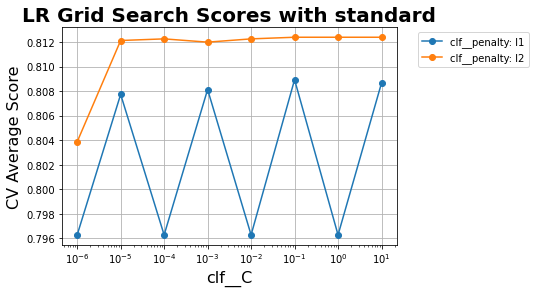

In [17]:
# Calling Method to plot_grid_search

clf__C = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
clf__penalty = ['l1', 'l2']


plot_grid_search(search_lr.cv_results_, 
                 clf__C, 
                 clf__penalty, 
                 'clf__C', 
                 'clf__penalty',
                 'with standard')





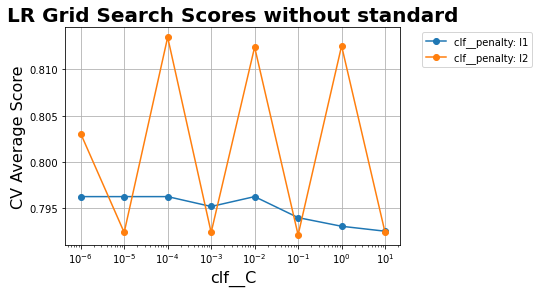

In [18]:
# Calling Method to plot_grid_search

clf__C = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
clf__penalty = ['l1', 'l2']


plot_grid_search(search_lr_2.cv_results_, 
                 clf__C, 
                 clf__penalty, 
                 'clf__C', 
                 'clf__penalty',
                 'without standard')



In [19]:
# save best LR model
best_LR_model = search_lr.best_estimator_

### 3.2.2 K Neighbors Classifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier 

# use pipline to train KNeighbors model
pipe_knn = Pipeline([('sc', StandardScaler()),
                    ('clf', KNeighborsClassifier())
                    ])
pipe_knn.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_knn.score(X_test, y_test))

Test accuracy: 0.827


In [21]:
# check details of KNN params.keys
pipe_knn.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sc', 'clf', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'clf__algorithm', 'clf__leaf_size', 'clf__metric', 'clf__metric_params', 'clf__n_jobs', 'clf__n_neighbors', 'clf__p', 'clf__weights'])

### - Tuning the hyper-parameters of K Neighbors
#### - [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [22]:
# knn with StandardScaler
pipe_knn = Pipeline([('sc', StandardScaler()),
                    ('clf', KNeighborsClassifier()) 
                    ])

parameters = {
    'clf__n_neighbors': np.arange(1,25,3)
}

search_knn = GridSearchCV(estimator = pipe_knn,
                         param_grid = parameters,
                         cv = 5, # cross-validation generator
                         return_train_score = True)
search_knn.fit(X_train, y_train)

print_grid_search_metrics(search_knn)

Best score: 0.8354666666666667
Best parameters set:
clf__n_neighbors:13


In [23]:
# show all results
search_knn.cv_results_

{'mean_fit_time': array([0.0143292 , 0.01370883, 0.01372938, 0.01371922, 0.01350455,
        0.01366968, 0.01364322, 0.01364622]),
 'std_fit_time': array([0.0016911 , 0.00018917, 0.00030413, 0.000383  , 0.00020558,
        0.00044451, 0.00013687, 0.0002113 ]),
 'mean_score_time': array([0.06753383, 0.09594679, 0.10998716, 0.12191243, 0.13155165,
        0.13926244, 0.1462533 , 0.15346265]),
 'std_score_time': array([0.00152522, 0.00079707, 0.00147843, 0.00204954, 0.00159073,
        0.00214257, 0.0019058 , 0.00274426]),
 'param_clf__n_neighbors': masked_array(data=[1, 4, 7, 10, 13, 16, 19, 22],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__n_neighbors': 1},
  {'clf__n_neighbors': 4},
  {'clf__n_neighbors': 7},
  {'clf__n_neighbors': 10},
  {'clf__n_neighbors': 13},
  {'clf__n_neighbors': 16},
  {'clf__n_neighbors': 19},
  {'clf__n_neighbors': 22}],
 'split0_test_score': array([0.804   

In [24]:
# knn without StandardScaler
pipe_knn_2 = Pipeline([
                    ('clf', KNeighborsClassifier()) 
                    ])

parameters = {
    'clf__n_neighbors': np.arange(1,25,3)
}

search_knn_2 = GridSearchCV(estimator = pipe_knn_2,
                         param_grid = parameters,
                         cv = 5, # cross-validation generator
                         return_train_score = True)
search_knn_2.fit(X_train, y_train)

print_grid_search_metrics(search_knn_2)

Best score: 0.796
Best parameters set:
clf__n_neighbors:22


### - compare knn with StandardScaler & without StandardScaler

In [25]:
def plt_knn(result_1, result_2, clf__n_neighbors, name_list):
    fig, ax = plt.subplots()
    
    ax.plot(clf__n_neighbors, result_1, '-o')
    ax.plot(clf__n_neighbors, result_2, '-*')
    
    plt.legend(name_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    ax.set_title("KNN Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel('clf__n_neighbors', fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')

In [26]:
result_1 = search_knn.cv_results_['mean_test_score']
result_2 = search_knn_2.cv_results_['mean_test_score']
clf__n_neighbors = np.arange(1,25,3)
name_list = ['with StandardScaler', 'without StandardScaler']

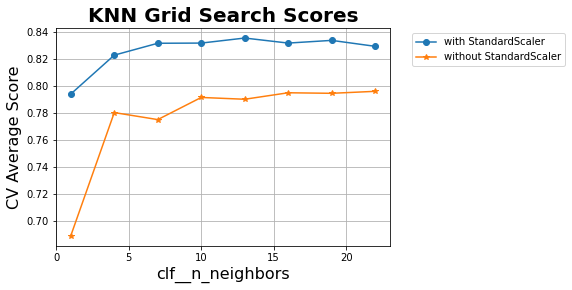

In [27]:
plt_knn(result_1, result_2, clf__n_neighbors, name_list)

In [28]:
# save best KNN model
best_KNN_model = search_knn.best_estimator_

### 3.2.3 Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
# use pipline to train KNeighbors model
pipe_rf = Pipeline([('sc', StandardScaler()),
                    ('clf', RandomForestClassifier())
                    ])
pipe_rf.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_rf.score(X_test, y_test))

Test accuracy: 0.861


In [30]:
# check details of RF params.keys
pipe_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sc', 'clf', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_jobs', 'clf__oob_score', 'clf__random_state', 'clf__verbose', 'clf__warm_start'])

### - Tuning the hyper-parameters of Random Forest
#### - [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [31]:
# RF with StandardScaler
pipe_rf = Pipeline([('sc', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=1)) 
                    ])

parameters = {
    'clf__n_estimators': np.arange(10,150,10)
}

search_rf = GridSearchCV(estimator = pipe_rf,
                         param_grid = parameters,
                         cv = 5, # cross-validation generator
                         return_train_score = True)
search_rf.fit(X_train, y_train)

print_grid_search_metrics(search_rf)

Best score: 0.8670666666666665
Best parameters set:
clf__n_estimators:140


In [32]:
print("search_rf mean_test_score:\n", search_rf.cv_results_['mean_test_score'])

search_rf mean_test_score:
 [0.8532     0.8612     0.86186667 0.86346667 0.8636     0.8648
 0.86506667 0.864      0.8648     0.8656     0.86506667 0.86586667
 0.86653333 0.86706667]


In [33]:
# RF without StandardScaler
pipe_rf_2 = Pipeline([
                    ('clf', RandomForestClassifier(random_state=1)) 
                    ])

parameters = {
    'clf__n_estimators': np.arange(10,150,10)
}

search_rf_2 = GridSearchCV(estimator = pipe_rf_2,
                         param_grid = parameters,
                         cv = 5, # cross-validation generator
                         return_train_score = True)
search_rf_2.fit(X_train, y_train)

print_grid_search_metrics(search_rf_2)

Best score: 0.8669333333333334
Best parameters set:
clf__n_estimators:140


In [34]:
print("search_rf without standard mean_test_score:\n", search_rf_2.cv_results_['mean_test_score'])

search_rf without standard mean_test_score:
 [0.85293333 0.86093333 0.8616     0.86293333 0.86346667 0.86493333
 0.86533333 0.86426667 0.86506667 0.86573333 0.86506667 0.86626667
 0.8668     0.86693333]


### - compare knn with StandardScaler & without StandardScaler

In [35]:
def plt_rf(result_1, result_2, clf__n_estimators, name_list):
    fig, ax = plt.subplots()
    
    ax.plot(clf__n_estimators, result_1, '-o')
    ax.plot(clf__n_estimators, result_2, '-*')
    
    plt.legend(name_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    ax.set_title("RF Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel('clf__n_estimators', fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')

In [36]:
result_1 = search_rf.cv_results_['mean_test_score']
result_2 = search_rf_2.cv_results_['mean_test_score']
clf__n_estimators = np.arange(10,150,10)
name_list = ['with StandardScaler', 'without StandardScaler']

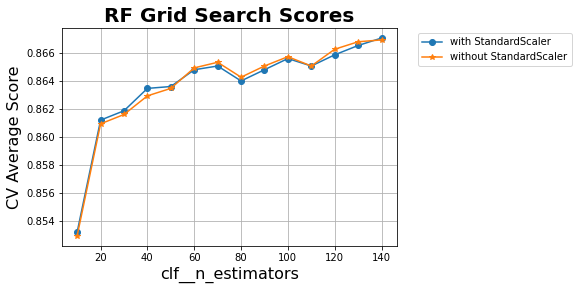

In [37]:
plt_rf(result_1, result_2, clf__n_estimators, name_list)

In [38]:
# save best RF model
best_RF_model = search_rf.best_estimator_

### 3.4  Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

#### - [ Confusion Matrix ](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

#### - [ ConfusionMatrixDisplay, RocCurveDisplay, and PrecisionRecallDisplay ](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py)

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

### 3.4.1 plot confusion matrix

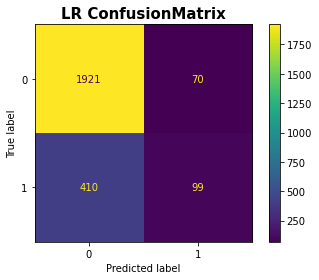

In [40]:
# LR
y_pred_lr = best_LR_model.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_lr_display = ConfusionMatrixDisplay(cm_lr).plot()
_ = cm_lr_display.ax_.set_title("LR ConfusionMatrix", fontweight='bold', fontsize=15)

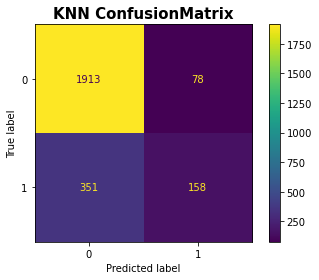

In [41]:
# KNN
y_pred_knn = best_KNN_model.predict(X_test)

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_display = ConfusionMatrixDisplay(cm_knn).plot()
_ = cm_knn_display.ax_.set_title("KNN ConfusionMatrix", fontweight='bold', fontsize=15)

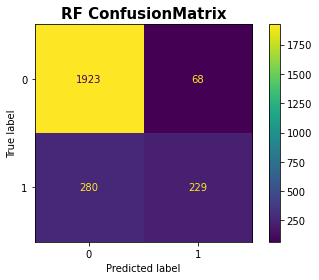

In [42]:
# RF
y_pred_rf = best_RF_model.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_display = ConfusionMatrixDisplay(cm_rf).plot()
_ = cm_rf_display.ax_.set_title("RF ConfusionMatrix", fontweight='bold', fontsize=15)


### 3.4.2 plot roc-curve

#### - WAY 1 to plot ROC
#### - [Drawing multiple ROC-Curves in a single plot](https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot)

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
# Instantiate the classfiers and make a list
classifiers = ['best_LR_model',
              'best_KNN_model',
              'best_RF_model']

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    yproba = eval(cls).predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

In [44]:
result_table.head()

,fpr,tpr,auc
classifiers,,,
best_LR_model,"[0.0, 0.0, 0.0020090406830738324, 0.0020090406...","[0.0, 0.0019646365422396855, 0.001964636542239...",0.772246
best_KNN_model,"[0.0, 0.0, 0.0010045203415369162, 0.0020090406...","[0.0, 0.011787819253438114, 0.0333988212180746...",0.794872
best_RF_model,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0019646365422396855, 0.005893909626719...",0.839215


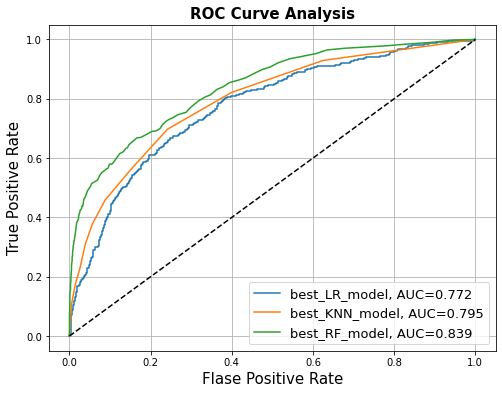

In [45]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.2))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.2))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.grid('on')

plt.show()

#### - WAY 2 to plot ROC
#### - [show the different ROC curves for all the models](https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py)

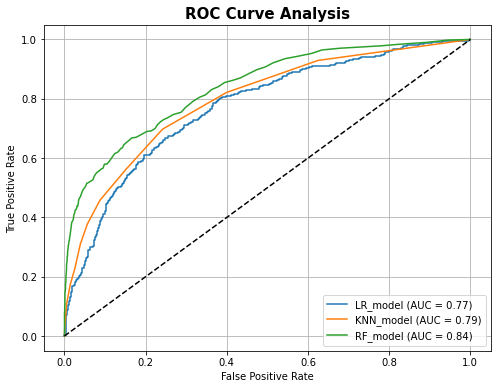

In [47]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(8,6))

models = [
   ('LR_model', best_LR_model),
   ('KNN_model',best_KNN_model),
   ('RF_model',best_RF_model)
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = plot_roc_curve(
        pipeline, X_test, y_test, ax=ax, name=name)
ax.plot([0,1], [0,1], color='black', linestyle='--')
ax.set_title('ROC Curve Analysis', fontweight='bold', fontsize=15)
ax.grid('on')

